In [7]:
from tensorflow.keras.datasets import fashion_mnist, mnist
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, Image

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


In [14]:
X, Y = getData(file_id)
num_class = len(set(Y))
#print(num_class)

Downloading...
From (original): https://drive.google.com/uc?id=14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S
From (redirected): https://drive.google.com/uc?id=14JkWQZ7HyteVjUiCF6AU3Y1OBKGtq41S&confirm=t&uuid=7d1ec1b3-30de-43cf-8e59-78756cd79ad8
To: /content/data.csv
100%|██████████| 301M/301M [00:01<00:00, 254MB/s]


In [ ]:
# Load the dataset from the local directory
def load_data(dataset_path):
    # Assuming the dataset is in a CSV file format in './dataset/' folder
    dataset_file = os.path.join(dataset_path, 'data.csv')  # Adjust if necessary
    df = pd.read_csv(dataset_file)
    
    # Extract pixel values and labels
    X = []
    Y = []
    
    for _, row in df.iterrows():
        Y.append(int(row['emotion']))
        X.append([int(p) for p in row['pixels'].split()])
    
    X, Y = np.array(X), np.array(Y)
    X = X.reshape(X.shape[0], img_size_target, img_size_target, 1)  # Reshaping images to (N, 48, 48, 1)
    
    return X, Y

# Load dataset
dataset_path = './dataset/'
X, Y = load_data(dataset_path)

# Normalize the images
X = X.astype('float32') / 255.0

Extracting Data and splitting train and test

In [16]:
#splitting data in train, test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [17]:
x_train.shape

(28709, 48, 48, 1)

In [18]:
distinct_labels = df['emotion'].unique()
print("Distinct Labels:", distinct_labels)

Distinct Labels: [0 2 4 6 3 5 1]


Data Preprocessing

In [19]:
#NOrmalizing the images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#reshaping the images
x_train = np.reshape(x_train, (len(x_train), 48, 48, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 48, 48, 1))  # adapt this if using `channels_first` image data format

#adding noise in data
noise_factor = 0.15

from skimage.util import random_noise

#noisy = random_noise(img, mode="poisson")
#just change the mode pf the noise to-->'gaussain',
x_train_noisy = random_noise(x_train, mode="s&p",clip=True, amount=noise_factor)
x_test_noisy = random_noise(x_test, mode="s&p",clip=True, amount=noise_factor)


#x_train_noisy = x_train + noise_factor * np.random.poisson(lam=(0,1), size=x_train.shape)
#x_test_noisy = x_test + noise_factor * np.random.poisson(lam=(0,1), size=x_test.shape)

#clipping put data near to 0--->0 aand data near to 1-->1(eg=0.3-->0 or 0.7-->1)
#x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Taking 100 images seperate for final testing

In [20]:
x_test_final_noisy = x_test_noisy[-100:]
x_test_noisy = x_test_noisy[:-100]

x_test_final_original = x_test[-100:]
x_test = x_test[:-100]

In [21]:
x_test_noisy.shape

(7078, 48, 48, 1)

Visualization of 10 Data

In [22]:
n = 10

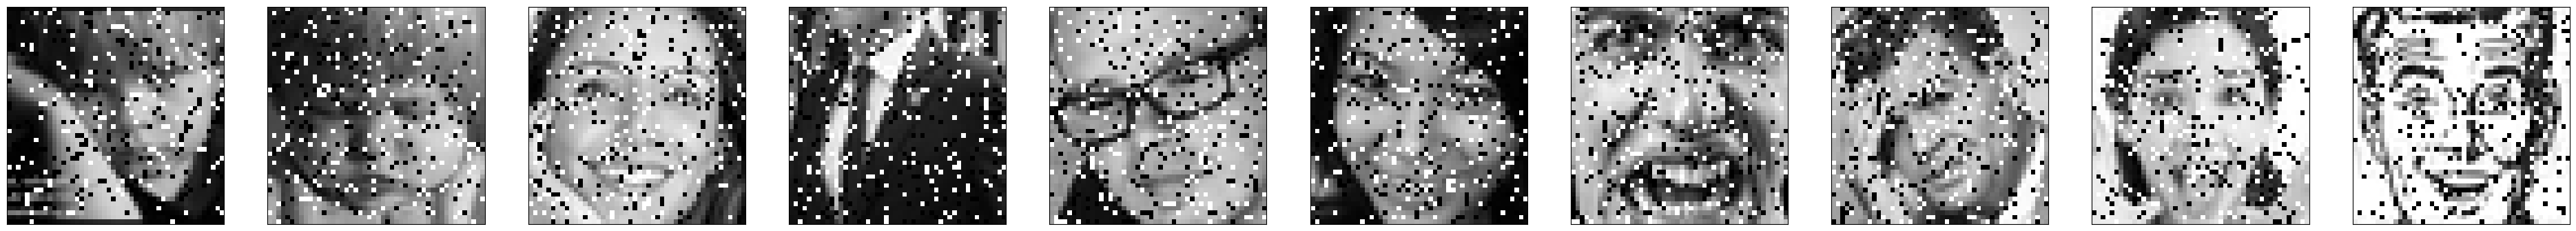

In [23]:
plt.figure(figsize=(48, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Construction of Model

In [24]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(0.5)(pool4)
#Middle
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(pool4)
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(convm)

    #upconv part
    deconv4 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)

    output_layer = Conv2D(1, (1,1), padding='same', activation='sigmoid')(uconv1)
    return output_layer


In [25]:
#Defining target image size and Input size and building model
img_size_target = 48
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer,64)

In [26]:
#Initializing and compiling model
model_unet = Model(input_layer, output_layer)
model_unet.compile(optimizer='adam', loss='MSE')

UNET Summary

In [27]:
model_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 48, 48, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 48, 48, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 24, 24, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 24, 24, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 24, 24, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 24, 24, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 12, 12, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 12, 12, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 12, 12, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 6, 6, 256)      │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 6, 6, 256)      │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 6, 6, 512)      │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 6, 6, 512)      │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 3, 3, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 3, 3, 512)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 38,384,001 (146.42 MB)

 Trainable params: 38,384,001 (146.42 MB)

 Non-trainable params: 0 (0.00 B)

Training Model

In [28]:
history = model_unet.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 230s 410ms/step - loss: 0.0168 - val_loss: 0.0022
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 190s 338ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 337ms/step - loss: 0.0013 - val_loss: 7.3173e-04
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 337ms/step - loss: 9.9055e-04 - val_loss: 6.1959e-04
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 322ms/step - loss: 8.4356e-04 - val_loss: 5.2358e-04
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 209s 338ms/step - loss: 7.4300e-04 - val_loss: 4.3324e-04
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 202s 338ms/step - loss: 6.6856e-04 - val_loss: 4.4555e-04
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 192s 317ms/step - loss: 6.1347e-04 - val_loss: 3.8190e-04
Epoch 9/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 325ms/step - loss: 5.6382e-04 - val_loss: 3.9675e-04
Epoch 10/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 325ms/step - loss: 5.4122e-04 - val_loss: 3.1955e-04


Making Prediction

In [29]:
predict = model_unet.predict(x_test_final_noisy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


Visualizing the prediction

Original Test images

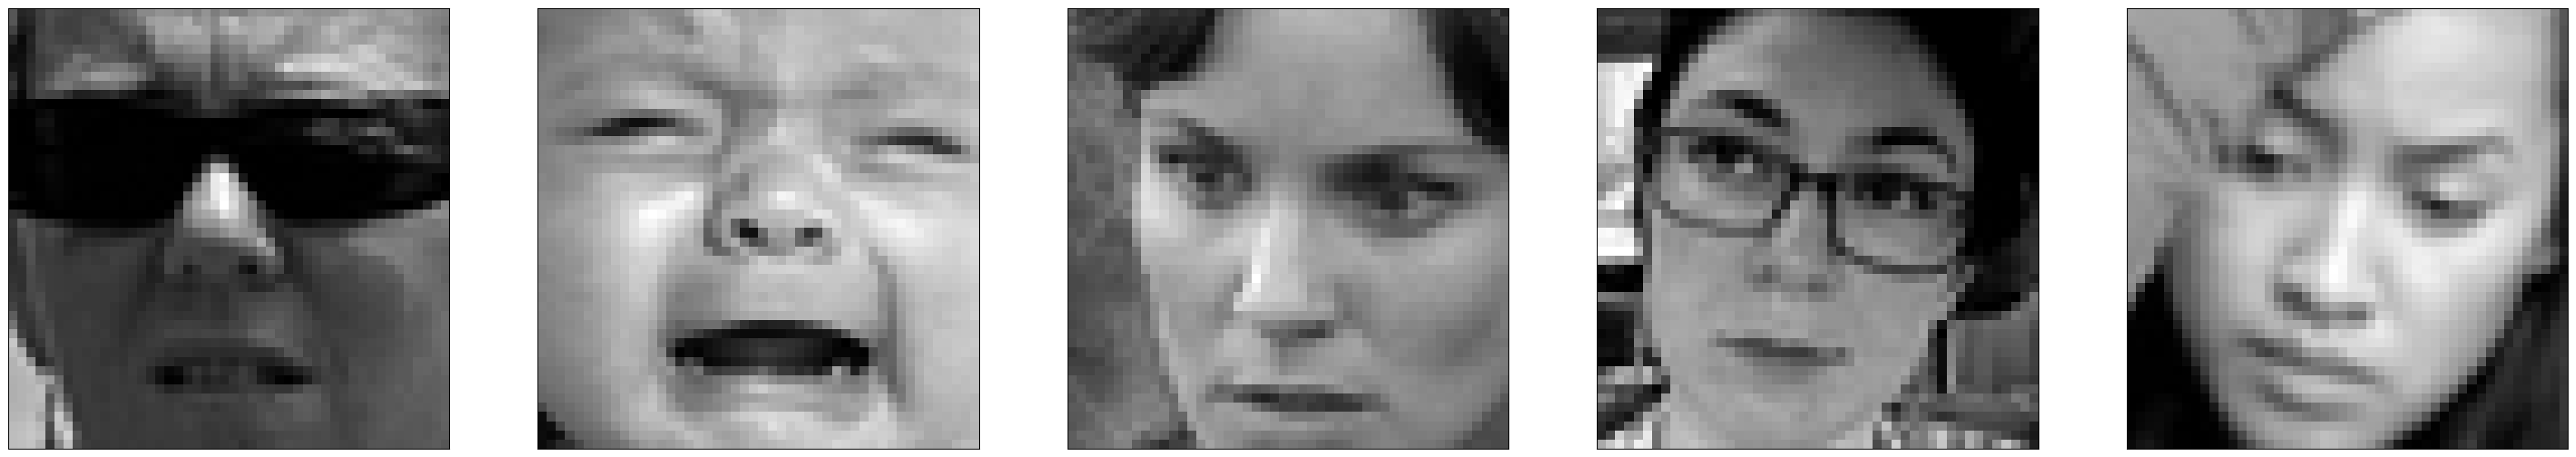

In [41]:
n=5
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_final_original[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Noised Test images

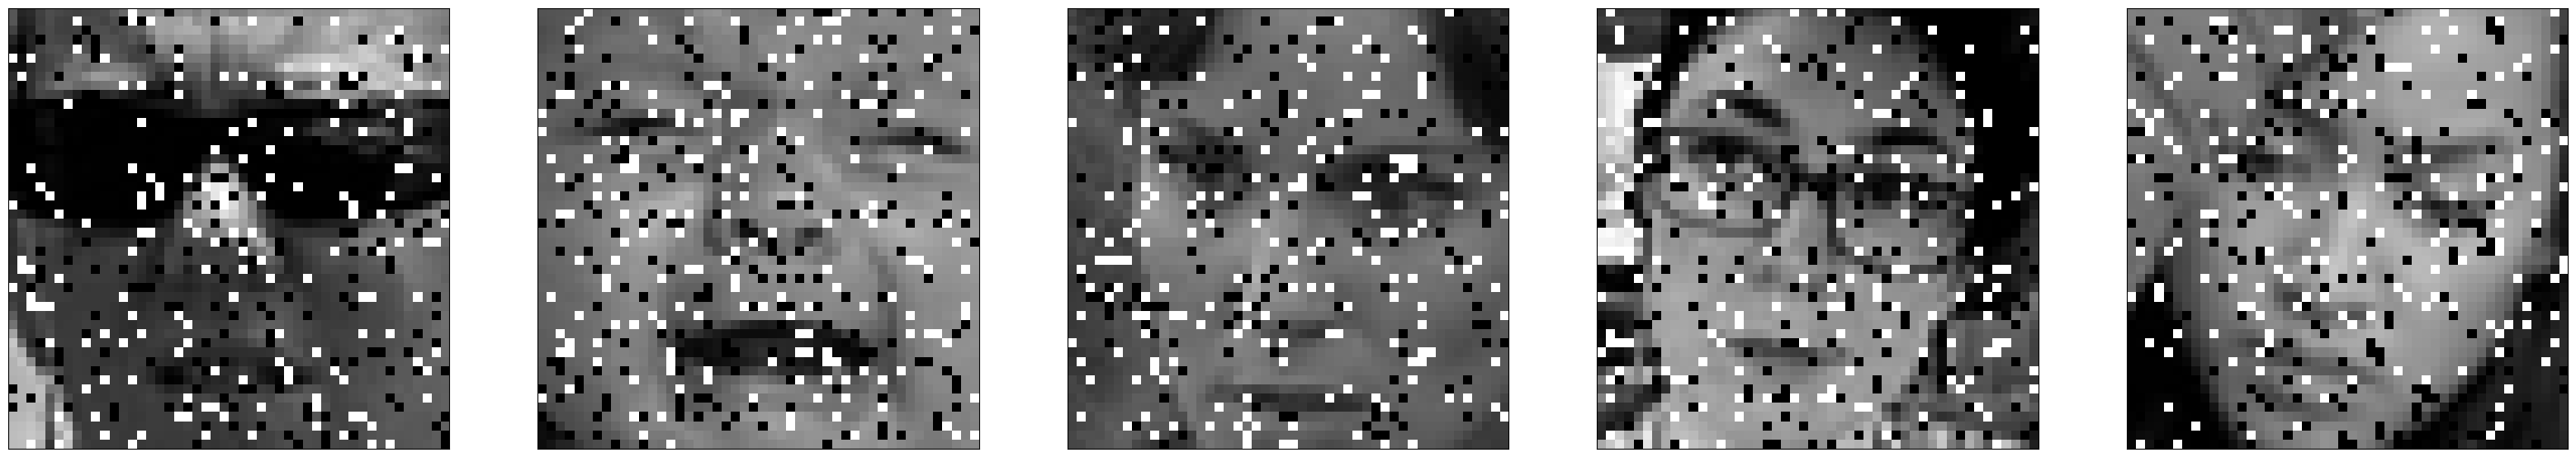

In [31]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_final_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Generated Test images

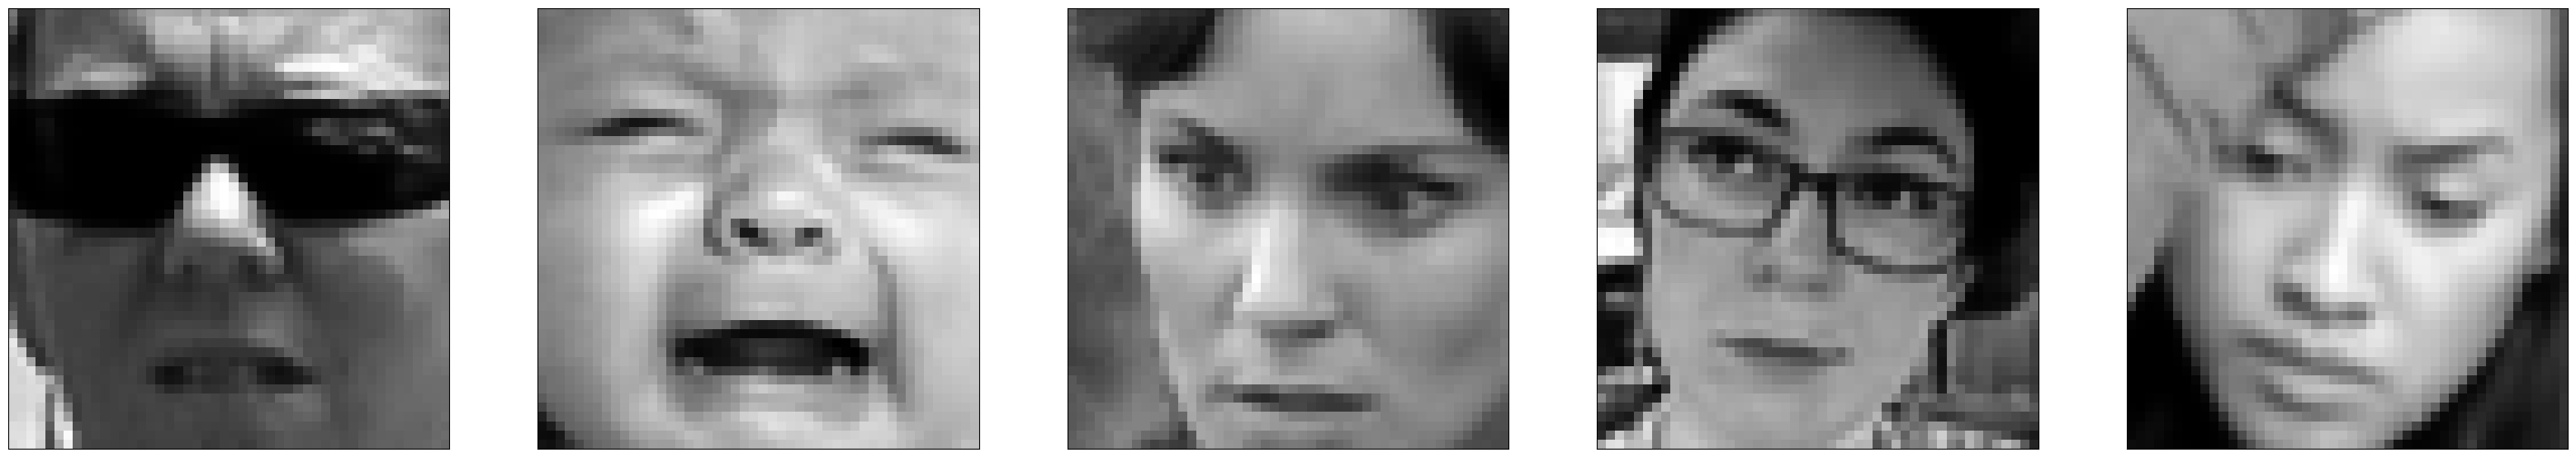

In [32]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [33]:
history.history

{'loss': [0.008082108572125435,
  0.001952514867298305,
  0.001231060246936977,
  0.000949793728068471,
  0.0008144170860759914,
  0.0007236916571855545,
  0.0006548489327542484,
  0.0006050275405868888,
  0.0005541048012673855,
  0.000524055038113147],
 'val_loss': [0.0021770873572677374,
  0.0010633771307766438,
  0.0007317277486436069,
  0.0006195917376317084,
  0.0005235818680375814,
  0.0004332429962232709,
  0.0004455474845599383,
  0.0003819041303358972,
  0.00039675444713793695,
  0.0003195479221176356]}

<Figure size 2000x1000 with 0 Axes>

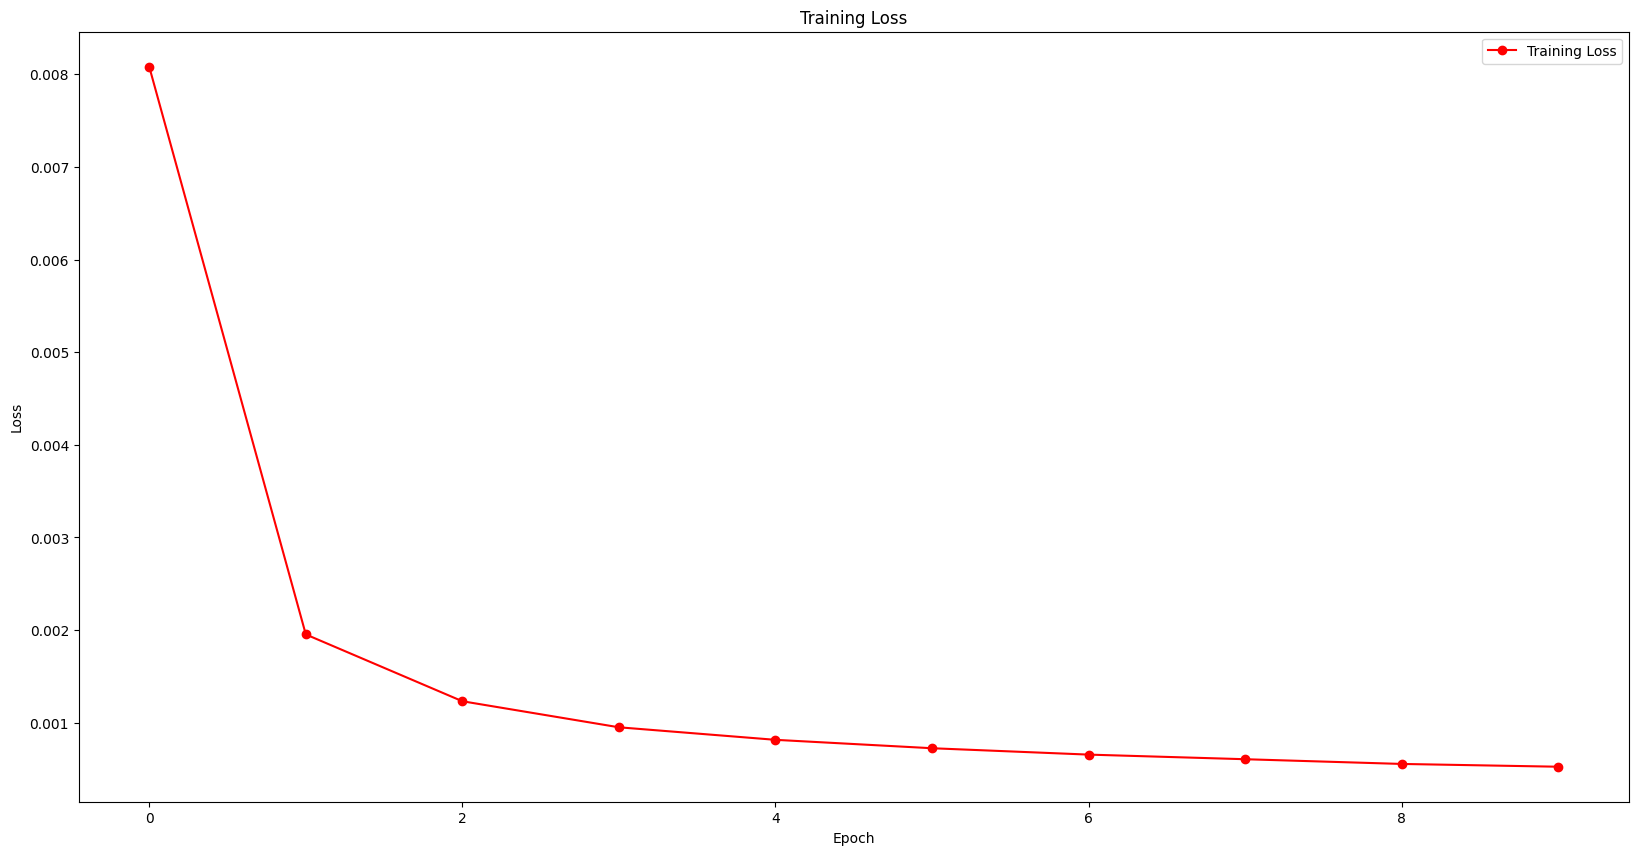

<Figure size 2000x1000 with 0 Axes>

In [34]:
epochs = range(len(history.history['loss']))

plt.plot(epochs,history.history['loss'],'r-o', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

<Figure size 2000x1000 with 0 Axes>

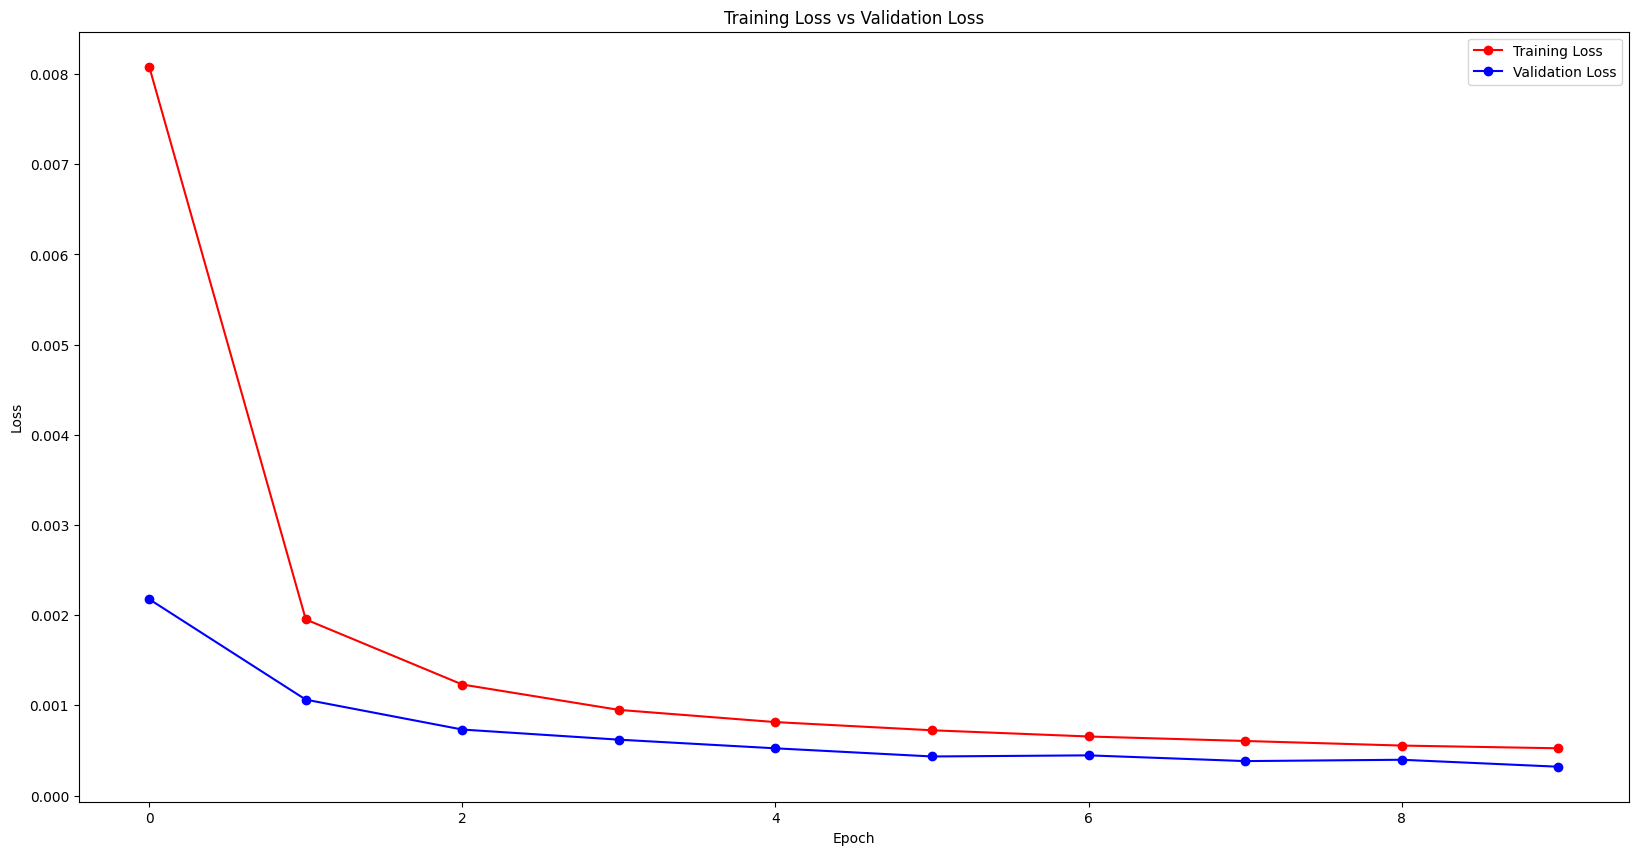

<Figure size 2000x1000 with 0 Axes>

In [35]:
epochs = range(len(history.history['loss']))

plt.plot(epochs,history.history['loss'],'r-o', label='Training Loss')
plt.plot(epochs,history.history['val_loss'],'b-o', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

MSE between Images

In [36]:
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import mean_squared_error as compare_mse
from skimage import data, img_as_float

In [37]:
# Fourth Image
compare_mse(x_test_final_original[3], predict[3])

0.000580388592965841

In [38]:
# whole dataset
compare_mse(x_test_final_original, predict)

0.00031081709165461994

In [39]:
# Save weights with a valid filename
model_unet.save_weights('model_weights.weights.h5')

# Save the entire model
model_unet.save('model_keras.h5')

Structural Similarity Index

In [48]:
#fouth Image
compare_ssim(x_test_final_original[3].squeeze(), predict[3].squeeze(), multichannel=False, win_size = 3, data_range = 1)

0.9652087127539859

In [49]:
# whole test dataset
compare_ssim(x_test_final_original.squeeze(), predict.squeeze(), multichannel=False, win_size = 3, data_range = 1)

0.994775482098802

PSNR

In [42]:
#fouth image
compare_psnr(x_test_final_original[3], predict[3])

32.36281131831603

In [43]:
#whole final dataset
compare_psnr(x_test_final_original, predict)

35.074951076085874

Compare noise and prediction

In [44]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np

psnrorg = np.zeros((100))
ssimorg = np.zeros((100))

for i in range(0, 100):
    # Specify the data range explicitly
    psnrorg[i] = compare_psnr(
        x_test_final_original[i],
        x_test_final_noisy[i],
        data_range=x_test_final_original[i].max() - x_test_final_original[i].min()
    )

    ssimorg[i] = compare_ssim(
        x_test_final_original[i],
        x_test_final_noisy[i],
        channel_axis=-1,  # Specify color channel
        win_size=3,
        data_range=x_test_final_original[i].max() - x_test_final_original[i].min()
    )

print("PSNR: %0.4f SSIM: %0.4f" % (np.average(psnrorg), np.average(ssimorg)))


PSNR: 12.4091 SSIM: 0.3940


In [45]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np

psnrpredict = np.zeros((100))
ssimpredict = np.zeros((100))

for i in range(0, 100):
    # Specify the data range explicitly
    psnrpredict[i] = compare_psnr(
        x_test_final_original[i],
        predict[i],
        data_range=x_test_final_original[i].max() - x_test_final_original[i].min()
    )

    ssimpredict[i] = compare_ssim(
        x_test_final_original[i],
        predict[i],
        channel_axis=-1,  # Specify color channel
        data_range=x_test_final_original[i].max() - x_test_final_original[i].min()
    )

print("PSNR: %0.4f SSIM: %0.4f" % (np.average(psnrpredict), np.average(ssimpredict)))


PSNR: 34.7061 SSIM: 0.9864
